# Sign language dataset handling
Data Analysis - ISAE 2020/2021 - Ahmad Berjaoui

In [1]:
import time #computation time analysis
import os #path handling
import numpy as np #numpy arrays operation
import matplotlib.pyplot as plt #plotting and image viewing
import cv2 #import OpenCV for image processing
from sklearn.model_selection import train_test_split #Data set splitting functions
from sklearn.neural_network import MLPClassifier #MLP classifier
from sklearn.decomposition import PCA #PCA reduction
from sklearn.ensemble import AdaBoostClassifier #Ada classifier
from sklearn.tree import DecisionTreeClassifier #Decision tree classifier
from sklearn.metrics import confusion_matrix #Confusion matrix
from sklearn.preprocessing import normalize #Normalization
#inline plots for nicer viewing
%matplotlib inline 

In [2]:
#dataPath = '/home/aib/Desktop/ISAE/solutions/data/signLanguage' # path to folder containing the sign language data
XFile = 'X.npy' # X
YFile = 'Y.npy' # Y

In [3]:
# Load input data and labels
X = np.load(XFile)
Y = np.load(YFile)
print(X.shape)
print(Y.shape)

(2062, 64, 64)
(2062, 10)


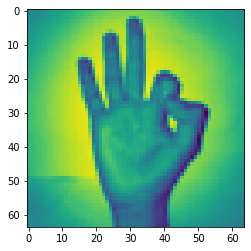

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
# Display an image and its label
imgIdx = 55
plt.imshow(X[imgIdx])
plt.show()
print(Y[imgIdx])

Let's define a function that converts the one-hot encoded labels to the corresponding sign language value, using the ClassLabels.csv mapping file

In [5]:
def labelToSignNumber(label):
  """
  Convert a one-hot encoded label to the
  corresponding sign language value.
  Mapping is given in the ClassLabels.txt
  file.
  
  Args:
    label: (numpy.array) One-hot encoded label

  Returns: (float) Sign language value
  """
  labelValue = np.argmax(label)
  mapping = {0:9,
             1:0,
             2:7,
             3:6,
             4:1,
             5:8,
             6:4,
             7:3,
             8:2,
             9:5}
  return mapping[labelValue]

Image 55 is a: 9


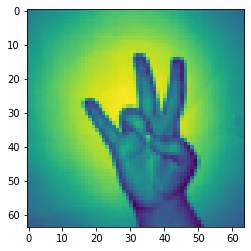

Image 600 is a: 7


In [6]:
# Let's test our function
y55 = labelToSignNumber(Y[55])
print('Image 55 is a: {}'.format(y55))
plt.imshow(X[600])
plt.show()
y600 = labelToSignNumber(Y[600])
print('Image 600 is a: {}'.format(y600))

## Filtering and features construction
Let's apply some edge detectors on an example image

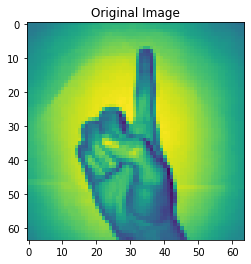

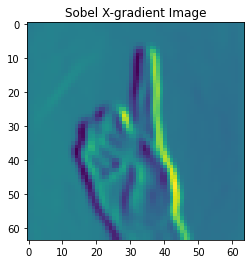

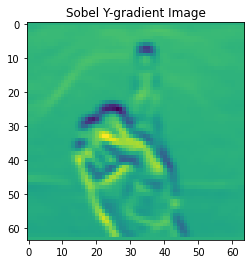

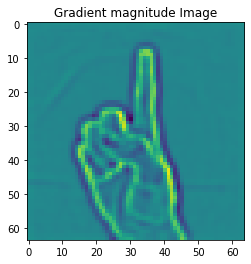

In [7]:
imgIdx = 900 #select an image index
img = X[imgIdx] #get the grayscale image matrix

sobelxImg = cv2.Sobel(img, #source image
                      cv2.CV_64F, #resulting image uses 64 bits float
                      1, #apply a Sobel filter along the X direction
                      0, #
                      ksize=5) #use a 5x5 kernel for filtering

sobelyImg = cv2.Sobel(img, #source image
                      cv2.CV_64F, #resulting image uses 64 bits float
                      0, #
                      1, #apply a Sobel filter along the Y direction
                      ksize=5) #use a 5x5 kernel for filtering

laplacianImg = cv2.Laplacian(img, #source image
                             cv2.CV_64F, #resulting image uses 64 bits float
                             ksize=5) #use a 5x5 kernel for to compute gradient magnitude

# let's display the images
def displayImg(_img,title=""):
  plt.imshow(_img)
  plt.title(title)
  plt.show()

displayImg(img,"Original Image")
displayImg(sobelxImg,"Sobel X-gradient Image")
displayImg(sobelyImg,"Sobel Y-gradient Image")
displayImg(laplacianImg,"Gradient magnitude Image")

Ces detecteurs de contours marchent bien, mais lors des tests d'algorithme de classification, nous avons invariablement aboutit à la conclusion que les images pré-traitées étaient plus dures à classifier. C'est peut-être par manque de chance, et nous aurions manqué le couple pré-traitement / classifieur qui donne d'excellent résultats. Néanmoins, nous laissons la piste du pré-traitement d'image de coté dans la suite de ce Notebook.

## 0 - Image filtering

In [8]:
X = np.load(XFile)
filteredX = np.array([cv2.Laplacian(img, cv2.CV_64F, ksize=5) for img in X])

## 1 - Data import and formatting 

In [9]:
# fullData = np.array([i.flatten() for i in filteredX])
fullData = np.array([i.flatten() for i in X])
print(fullData.shape)

(2062, 4096)


In [10]:
Y = np.load(YFile)
classData = np.array([labelToSignNumber(label) for label in Y])
print(classData.shape)

(2062,)


## 2 - Normalization

Les variations d'une image à une autre sont bien plus importantes pour certains pixels que pour d'autre. Ppur simplifier la tâche de nos classifieurs, on normalize chacune des features. Ainsi, ils n'ont qu'une dynamique à traiter, et les effets d'echelle ne viennent pas biaiser les calculs de distance [1].

In [11]:
fullData = normalize(fullData)

## 3 - Data splitting 

In [12]:
# Let's split the data into training data, and test data. Same splitting should be applied to classes.
# Here, the test data size is 10% of the full dataset
trainData,testData,trainY,testY = train_test_split(fullData,classData,test_size=0.1)
print(trainData.shape)
print(testData.shape)

(1855, 4096)
(207, 4096)


## 4 - PCA

Comme on a un problème en trés haute dimension, on réalise d'abord une Analyse en Composante principale. Il s'agit de trouver les directions de l'espace multi-dimensionel qui contiennent le plus d'information.

En pratique, on réalise une regression lineaire des points d'entrainement, pour extraire la direction qui explique le mieux les données. Puis on cherche la seconde direction othogonale à la première, par une nouvelle regression linéaire. Puis la troisième direction orthogonale aux deux premières, et ainsi de suite [2] . Au final, on a une nouvelle base orthogonale de l'espace des features, et la matrice de changement de base.

On réalise le changement de base pour tous les points d'entrainement. Alors leur matrice de corrélation devient diagonale, avec les coéfficients diagonaux rangés par ordre décroissant [1]. On peut alors choisir d'ignorer les dernières dimensions, qui contiennent peu d'information utile. Et l'on a alors réussi à réduire drastiquement la dimension du problème, à peu de frais en information ni en temps.

(1855, 89)
(207, 89)
[2.1330137  1.8823045  1.7033125  1.631308   1.5958494  1.3791438
 1.3279074  1.1667391  1.1392283  1.111431   1.0860157  1.0353802
 1.0114017  0.97273105 0.95044553 0.92371416 0.90168613 0.8683638
 0.82449156 0.8010061  0.78935325 0.76688284 0.74550873 0.7206563
 0.70066905 0.6804824  0.6706281  0.64707345 0.63145065 0.61610407
 0.6071768  0.59489626 0.58920574 0.5859319  0.55635303 0.5535093
 0.5419105  0.53847694 0.5302879  0.5271482  0.51285    0.50484353
 0.50384945 0.49744105 0.48723567 0.4861087  0.4809174  0.47280625
 0.46006057 0.45558658 0.45313954 0.44875565 0.44188312 0.44089285
 0.43902218 0.42720014 0.4268343  0.42359588 0.415419   0.41416332
 0.40647498 0.4028852  0.397676   0.39315844 0.38908595 0.38763034
 0.38256136 0.37977192 0.376525   0.37143457 0.36719263 0.3650569
 0.36366132 0.35837302 0.35537422 0.35316792 0.35087043 0.34529427
 0.34359634 0.3418295  0.33740002 0.33586198 0.33511895 0.33016962
 0.32811236 0.32741764 0.3243432  0.31889957 0.

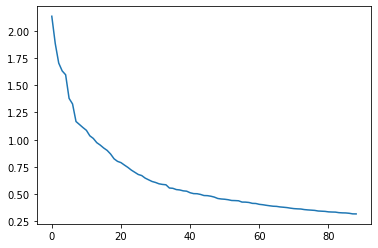

In [13]:
pca = PCA(n_components=0.8, svd_solver="auto")
pcaTrainData = pca.fit_transform(trainData)
pcaTestData = pca.transform(testData)
print(pcaTrainData.shape)
print(pcaTestData.shape)
print(pca.singular_values_)
plt.plot(pca.singular_values_)

## 7 - MLP classification

On a déjà expliqué l'idée de cet algorithme dans le notebook sur les Iris. Notons simplement que l'on l'applique sur les données en sortie de la PCA, pour limiter la taille de l'_input layer_ et donc le temps d'entrainement ainsi que le nombre d'hyperparamètres.

In [14]:
# Let's build a linear classifier out of our training data and use euclidian distance as a metric.
# This can be replaced by a custom metric
start_time = time.time()
mlp = MLPClassifier(solver='lbfgs', activation='logistic', max_iter=1e3)
mlp.fit(pcaTrainData,trainY)

MLPClassifier(activation='logistic', max_iter=1000.0, solver='lbfgs')

In [15]:
# Check the classifier's performance on the training data
trainPredictions = mlp.predict(pcaTrainData)
trainCM = confusion_matrix(y_pred=trainPredictions,y_true=trainY)
print(trainCM)

[[181   0   0   0   0   0   0   0   0   0]
 [  0 185   0   0   0   0   0   0   0   0]
 [  0   0 184   0   0   0   0   0   0   0]
 [  0   0   0 185   0   0   0   0   0   0]
 [  0   0   0   0 184   0   0   0   0   0]
 [  0   0   0   0   0 193   0   0   0   0]
 [  0   0   0   0   0   0 193   0   0   0]
 [  0   0   0   0   0   0   0 182   0   0]
 [  0   0   0   0   0   0   0   0 181   0]
 [  0   0   0   0   0   0   0   0   0 187]]


On voit que notre classifieur MLP réalise des prédiction parfaites pour les données d'entrainement. C'est inquiétant quand à l'overfitting, surtout que la détéction du language des signes est déjà un problème non-trivial et légerement bruité.

## 8 - MLP classifier performance 

In [16]:
# Check the classifier's performance on the test data
predictions = mlp.predict(pcaTestData)
testCM = confusion_matrix(y_pred=predictions,y_true=testY)
print(testCM)
accuracy = float(np.sum([testCM[i][i] for i in range(10)]))/float(len(testY))
print(accuracy)
print("--- %s seconds ---" % (time.time() - start_time))

[[22  0  0  0  1  0  1  0  0  0]
 [ 0 18  1  1  1  0  0  0  0  0]
 [ 0  0 20  2  0  0  0  0  0  0]
 [ 0  1  1 16  0  1  0  2  0  0]
 [ 0  0  0  0 18  1  1  1  0  2]
 [ 0  0  0  0  0 14  0  0  0  0]
 [ 0  0  0  0  0  0 13  1  0  0]
 [ 1  0  0  0  1  0  1 18  1  2]
 [ 0  1  0  1  1  0  0  0 22  2]
 [ 0  0  0  0  0  0  0  0  0 17]]
0.8599033816425121
--- 4.302969455718994 seconds ---


Et pourtant, les performances sur les données de test restent excellentes, à 85%. Il y a bien eu un petit overfitting, mais il n'a pas été suffisant pour rendre le classifieur MLP inutile.

Pourtant, quantitativement, il était raisonnable de craindre que le nombre d'hyperparamètres ($100 \times (89 + 10) \approx 10^{4}$) du MLP soit trop haut par rapport au nombre de points d'entrainement ($\approx 1900$), et donc que le classifieur ai fitté du bruit... <br>
Notre hypothèse est que l'on a éliminé une large partie du bruit dans les données lors de la PCA, en ne conservant que les directions contenant le plus de pouvoir explicatif. Ainsi le MLP a bien fitté du bruit, mais celui-ci était une quantité négligeable, donc la classification reste correcte. Un peu comme sur l'image suivante [3]:
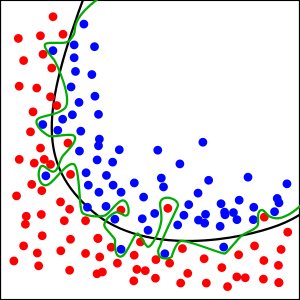

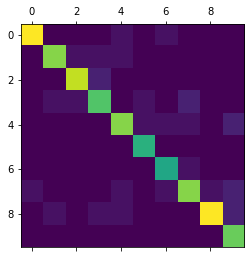

In [17]:
# You can also plot the confusion matrix
plt.matshow(testCM)

## 9 - Decision tree classification

Pour montrer un vrai exemple d'overfitting, on essaie un classifieur par arbre de décision sur ce même problème. Ce classifieur a déjà été décrit dans le notebook sur le Titanic.

In [18]:
# Let's build a decision tree classifier.
start_time = time.time()
dtc = DecisionTreeClassifier()
dtc.fit(pcaTrainData,trainY)

DecisionTreeClassifier()

In [19]:
# Check the classifier's performance on the training data
trainPredictions = dtc.predict(pcaTrainData)
trainCM = confusion_matrix(y_pred=trainPredictions,y_true=trainY)
print(trainCM)

[[181   0   0   0   0   0   0   0   0   0]
 [  0 185   0   0   0   0   0   0   0   0]
 [  0   0 184   0   0   0   0   0   0   0]
 [  0   0   0 185   0   0   0   0   0   0]
 [  0   0   0   0 184   0   0   0   0   0]
 [  0   0   0   0   0 193   0   0   0   0]
 [  0   0   0   0   0   0 193   0   0   0]
 [  0   0   0   0   0   0   0 182   0   0]
 [  0   0   0   0   0   0   0   0 181   0]
 [  0   0   0   0   0   0   0   0   0 187]]


On voit que les prédiction du classifieur sur les données d'entrainnement sont parfaites, comme pour le classifieur MLP. On peut donc craindre de l'overfitting.

## 10 - Decision tree classifier performance 

In [20]:
# Check the classifier's performance on the test data
predictions = dtc.predict(pcaTestData)
testCM = confusion_matrix(y_pred=predictions,y_true=testY)
print(testCM)
accuracy = float(np.sum([testCM[i][i] for i in range(len(testCM))]))/float(len(testY))
print(accuracy)
print("--- %s seconds ---" % (time.time() - start_time))

[[16  1  2  1  0  0  1  1  1  1]
 [ 0 14  3  1  1  0  1  1  0  0]
 [ 3  0 12  2  0  0  4  1  0  0]
 [ 0  1  3 12  0  2  2  0  1  0]
 [ 3  0  2  0  4  2  5  1  4  2]
 [ 2  1  0  0  4  4  1  0  0  2]
 [ 1  1  0  1  4  1  3  1  2  0]
 [ 1  0  2  1  3  0  3 10  2  2]
 [ 3  1  1  0  4  0  2  0 11  5]
 [ 0  2  2  1  1  0  2  0  0  9]]
0.45893719806763283
--- 0.14203262329101562 seconds ---


Et effectivement, on a une nette perte de performance sur les points de test : on est passé de 100% à 45% !

Pourtant, on a aussi utilisé les données traitées par la PCA, donc avec une grosse partie du bruit en plus. Nous ne sommes pas tout à fait certain de notre interprétation, mais on pense que l'on vient d'illustrer la différence de susceptibilité entre l'overfitting du MLP et l'arbre de décision.

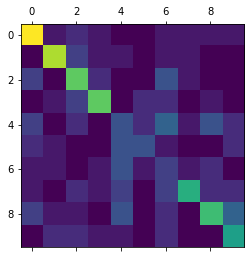

In [21]:
# You can also plot the confusion matrix
plt.matshow(testCM)

## Références

[1] Notes de cours

[2] Page Wikipedia sur la PCA : https://en.wikipedia.org/wiki/Principal_component_analysis

[3] Page Wikipedia sur l'overfitting : https://en.wikipedia.org/wiki/Overfitting